In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Data

In [264]:
df = pd.read_csv(r"C:\Users\shaur\Desktop\train.csv")

### Checking the Data

In [265]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [267]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,7981,CA-2015-103800,03-01-2015,07-01-2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095.0,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448
1,740,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784
2,741,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736
3,742,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540
4,1760,CA-2015-141817,05-01-2015,12-01-2015,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143.0,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536


In [268]:
df.shape

(9800, 18)

### Setting up the Time Data with Date as an index and summing up in montly format

In [281]:
df["Date"] = pd.to_datetime(df["Order Date"])

In [282]:
df = df.set_index("Date")

In [283]:
ts = pd.DataFrame(df.Sales.resample("M").sum())

In [284]:
ts.tail()

,Sales
Date,
2018-08-31,75408.7840
2018-09-30,73153.3640
2018-10-31,65501.1622
2018-11-30,87997.6400
2018-12-31,56959.2358


In [285]:
ts.shape

(48, 1)

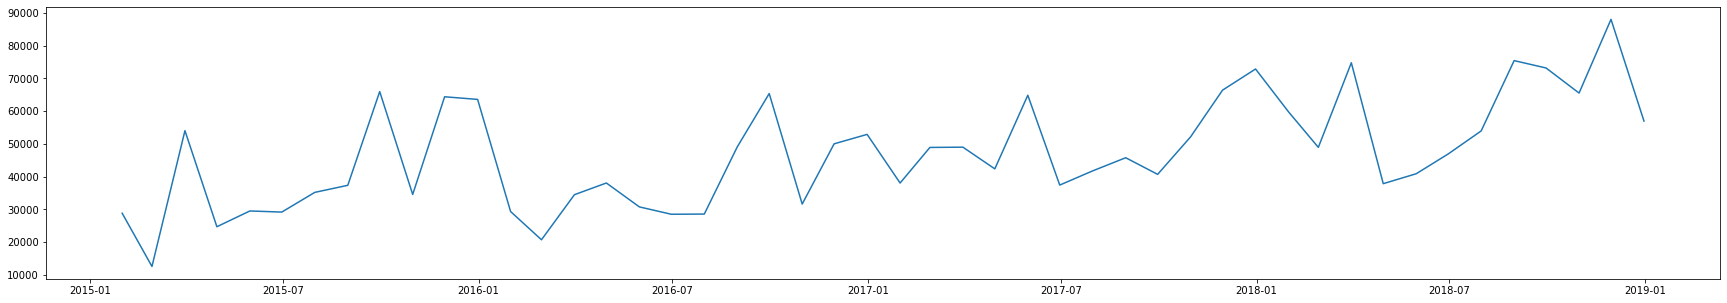

In [286]:
plt.figure(figsize=(30,5))
plt.plot(ts)

### Checking the stationarity with Dicky Fuller Test

In [287]:
from statsmodels.tsa.stattools import adfuller
dtest = adfuller(ts)
print('P-Value: %f' % dtest[1])

P-Value: 0.696763


### P value is more than 0.05 hence Conversion require, Log Transformation and Diffrancing needed

In [288]:
ts_log = np.log(ts)

In [289]:
ts_log_diff = ts_log - ts_log.shift(1)
ts_log_diff = ts_log_diff.dropna(axis=0)

In [290]:
dtest = adfuller(ts_log_diff)
print('P-Value: %f' % dtest[1])

P-Value: 0.000068


<AxesSubplot:xlabel='Date'>

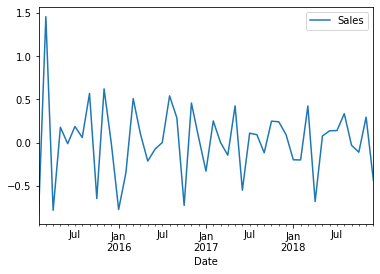

In [291]:
ts_log_diffS.plot()

### Checking Decompose

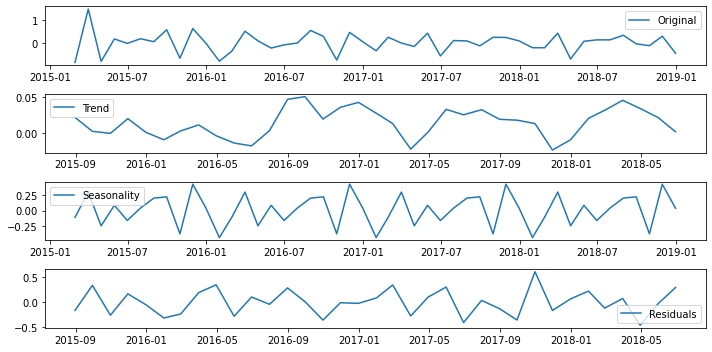

In [292]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(ts_log_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Trend seems to be more stable but increasing in long term, Seasonality seems to touch the peak during the december times

### Checking ACF and PACF 

In [293]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

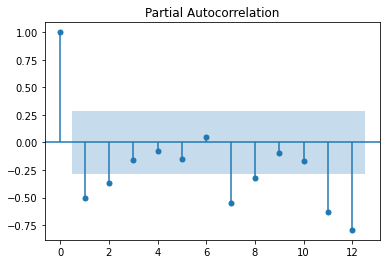

In [294]:
PACF = plot_pacf(ts_log_diff,lags=12)

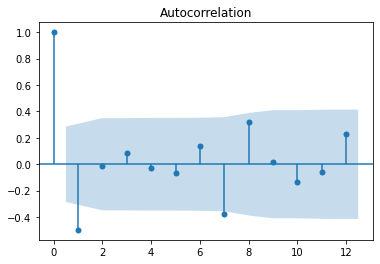

In [295]:
ACF = plot_acf(ts_log_diff,lags=12)

### Both ACF And PACF seems to have good correlation at 7th lag

### calling Library

In [296]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### Spliting the data from 48 months to 38:10 to check the accuracy of the model

In [388]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ts,test_size=0.20,shuffle=False)

In [389]:
train.shape,test.shape

((38, 1), (10, 1))

In [390]:
from statsmodels.tsa.arima_model import ARIMA

In [391]:
model=sm.tsa.statespace.SARIMAX(train,order=(7, 1, 7),seasonal_order=(1 ,0 ,0 ,12),enforce_stationarity=True,enforce_invertibility=True,trend="n",simple_differencing=False,n_jobs=-1)
results=model.fit()

In [392]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   38
Model:             SARIMAX(7, 1, 7)x(1, 0, [], 12)   Log Likelihood               -3765.557
Date:                             Thu, 21 Apr 2022   AIC                           7563.115
Time:                                     13:25:57   BIC                           7588.890
Sample:                                 01-31-2015   HQIC                          7572.202
                                      - 02-28-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5174      0.001   -588.521      0.000      -0.519      -0.516
ar.L2         -0.2250      0.001   -414.690      0.000      -0.226      -0.224
ar.L3         -0.6972      0.001  -1142.233      0.000      -0.698      -0.696
ar.L4         -0.7202      0.001  -1352.634      0.000      -0.721      -0.719
ar.L5         -0.1921      0.000   -479.629      0.000      -0.193      -0.191
ar.L6         -0.5619      0.001   -608.235      0.000      -0.564      -0.560
ar.L7         -0.9642      0.000  -3215.191      0.000      -0.965      -0.964
ma.L1         -0.2878      0.134     -2.148      0.032      -0.550      -0.025
ma.L2          0.2973      0.153      1.941      0.052      -0.003       0.597
ma.L3          0.1951      0.023      8.340      0.000       0.149       0.241
ma.L4         -0.1664      0.022     -7.437      0.000      -0.210      -0.123
ma.L5         -0.2735      0.155     -1.767      0.077      -0.577       0.030
ma.L6          0.3192      0.131      2.430      0.015       0.062       0.577
ma.L7         -0.9789      0.002   -416.616      0.000      -0.984      -0.974
ar.S.L12       0.9959      0.000   9732.029      0.000       0.996       0.996
sigma2      2.677e+05   1.61e-05   1.66e+10      0.000    2.68e+05    2.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 1.51
Prob(Q):                              0.47   Prob(JB):                         0.47
Heteroskedasticity (H):              12.14   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.9e+24. Standard errors may be unstable.
"""

In [398]:
prediction = results.forecast(steps=10)

### Comparing the results from our prediction and the test data that was split

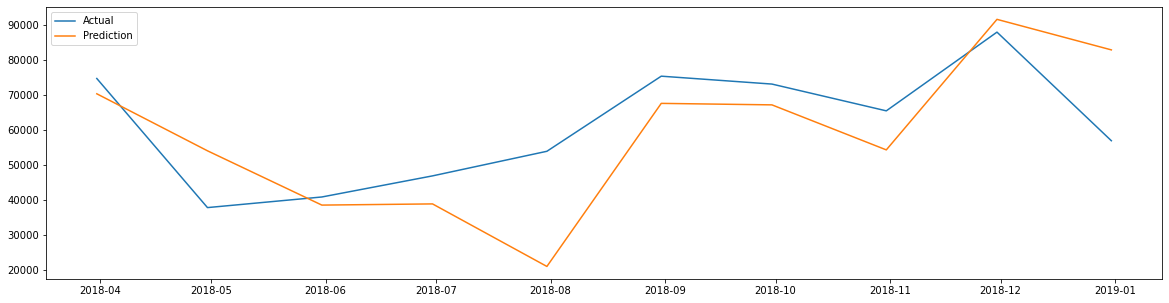

In [414]:
plt.figure(figsize=(20,5))
plt.plot(test,label="Actual")
plt.legend(loc='best')
plt.plot(pd.DataFrame(prediction),label="Prediction")
plt.legend(loc='best')

In [400]:
concat = [prediction,test]

In [401]:
pd.concat(concat,axis=1)

,predicted_mean,Sales
2018-03-31,70375.824090,74748.6238
2018-04-30,54079.320614,37849.2156
2018-05-31,38563.441654,40882.4464
2018-06-30,38902.428710,46912.8475
2018-07-31,21029.318645,53942.7755
2018-08-31,67635.201083,75408.7840
2018-09-30,67208.460950,73153.3640
2018-10-31,54343.910546,65501.1622
2018-11-30,91648.834903,87997.6400
2018-12-31,82923.955025,56959.2358


In [402]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mse = mean_squared_error(y_true=test,y_pred=prediction)
mae = mean_absolute_error(y_true=test,y_pred=prediction)
rmse = np.sqrt(mse)
print('MAE: %f'%mae)
print('RMSE: %f'%rmse)
print('MSE: %f'%mse)

MAE: 11833.743686
RMSE: 15307.287536
MSE: 234313051.719678


### Creating the Data Frame to predict for the future

In [403]:
from pandas.tseries.offsets import DateOffset
pred_dates=pd.Series(pd.date_range("1/1/2019", freq="M", periods=14))
pred_dates_ts=pd.DataFrame(index=pred_dates[1:],columns=ts.columns)

In [404]:
pred = pd.concat([ts,pred_dates_ts])
pred['forecast'] = results.forecast(steps=24)

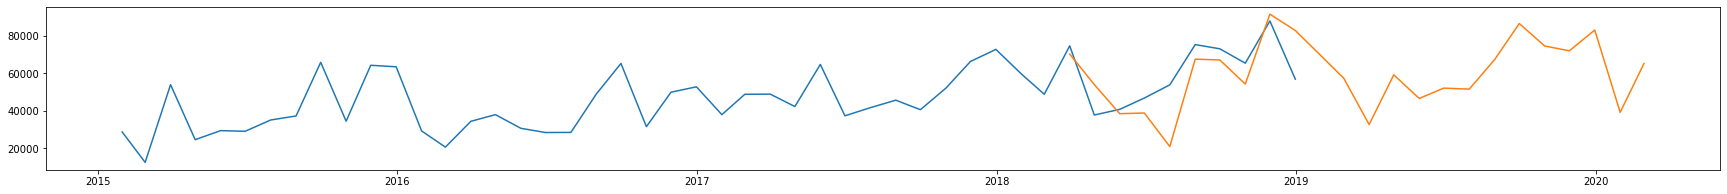

In [405]:
plt.figure(figsize=(30,3))
plt.plot(pred)

In [406]:
pred.iloc[35:55]

,Sales,forecast
2017-12-31,72847.0855,NaN
2018-01-31,59767.0910,NaN
2018-02-28,48928.8334,NaN
2018-03-31,74748.6238,70375.824090
2018-04-30,37849.2156,54079.320614
2018-05-31,40882.4464,38563.441654
2018-06-30,46912.8475,38902.428710
2018-07-31,53942.7755,21029.318645
2018-08-31,75408.7840,67635.201083
2018-09-30,73153.3640,67208.460950


In [366]:
pred.to_excel("Results.xlsx")